In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
from PIL import Image

In [ ]:
tf.compat.v1.disable_eager_execution()

USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


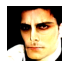

In [ ]:
import cv2

generator = hub.Module("https://tfhub.dev/google/progan-128/1")

with tf.device(device):
    latent = tf.placeholder(tf.float32, shape=(1, 512))
    z = latent
    np.random.seed(4208)
    latent_np = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    z_np = sess.run(z, feed_dict={latent: np.reshape(latent_np, (1,512))})
    img = generator(z_np).eval()
    img = (img * 255).astype(np.uint8)
    
img = img.reshape((128, 128, 3))
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches( 1, 1 )
plt.imshow(img)
plt.savefig('original.png', bbox_inches='tight', pad_inches=0, dpi=170)
# img = cv2.imread('original.png')
# print(img.shape)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


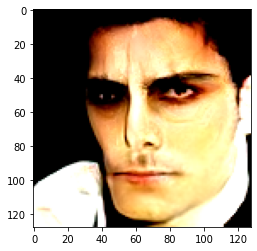

In [ ]:
tf.reset_default_graph()

img = (img / 255).astype(np.float32)

print(img)

truth = tf.Variable(img, tf.float32)
truth = tf.expand_dims(truth, 0)
truth = tf.cast(truth, tf.float32) 

plt.imshow((img * 255).astype(np.uint8))

np.random.seed(42)
zp1 = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))
zp = tf.Variable(zp1, dtype=tf.float32)

In [ ]:
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

reconstructed = generator(zp)
# loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, 2.0))
# loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, max_val=1))
loss_rec = tf.losses.mean_squared_error(labels=truth, predictions=reconstructed)
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step,
                                           10000, 0.005)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss_rec, var_list=zp)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(1000):
  _, loss_value, zp_val, eta = sess.run((train, loss_rec, zp, learning_rate))
  zp_val = np.clip(zp_val, -1, 1)
  z_loss = np.sqrt(np.sum(np.square(zp_val - z_np))/len(zp_val[0]))
  if i%100 == 0:
    print("%03d) eta=%03f, loss = %f, z_loss = %f" % (i, eta, loss_value*255*255, z_loss))

000) eta=0.100000, loss = 20625.424538, z_loss = 0.850612
100) eta=0.100000, loss = 2055.287213, z_loss = 0.886970
200) eta=0.100000, loss = 537.580590, z_loss = 0.863805
300) eta=0.100000, loss = 288.382636, z_loss = 0.851982
400) eta=0.100000, loss = 136.776262, z_loss = 0.839994
500) eta=0.100000, loss = 106.982541, z_loss = 0.829454
600) eta=0.100000, loss = 103.491527, z_loss = 0.818524
700) eta=0.100000, loss = 81.918165, z_loss = 0.806258
800) eta=0.100000, loss = 66.821630, z_loss = 0.796500
900) eta=0.100000, loss = 58.787711, z_loss = 0.786402


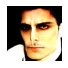

In [ ]:
img_rec = sess.run(generator(zp))

# print(img)

# plt.imshow((img * 255).astype(np.uint8))

img_rec = (img_rec * 255).astype(np.uint8)
img_rec = img_rec.reshape((128, 128, 3))
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches( 1, 1 )
plt.imshow(img_rec)
plt.savefig('reconstructed.png', bbox_inches='tight', pad_inches=0, dpi=170)

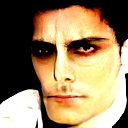

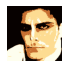

In [ ]:
from io import BytesIO
from sklearn.cluster import KMeans

PIL_image = Image.fromarray((img * 255).astype(np.uint8))

display(PIL_image)

buffer = BytesIO()
PIL_image.save(buffer, "JPEG", quality=10)

# ... do something else ...

# write the buffer to a file to make sure it worked
with open("photo-quality10.jpeg", "wb") as handle:
    buffer.seek(0)
    handle.write(buffer.getbuffer())

buffer = BytesIO()
PIL_image.save(buffer, "JPEG", quality=1)

# ... do something else ...

# write the buffer to a file to make sure it worked
with open("photo-quality1.jpeg", "wb") as handle:
    buffer.seek(0)
    handle.write(buffer.getbuffer())

kmeansimg = (img * 255).astype(np.uint8).reshape(-1, 3)

kmeans = KMeans(n_clusters=4)
kmeans.fit(kmeansimg)

compressed_image = kmeans.cluster_centers_[kmeans.labels_]
compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)

compressed_image = compressed_image.reshape(128, 128, 3)
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches( 1, 1 )
plt.imshow(compressed_image)
plt.savefig('kmeans4.png', bbox_inches='tight', pad_inches=0, dpi=170)

In [ ]:
tf.reset_default_graph()

# img = (img / 255).astype(np.uint8)

truth = tf.Variable(img, tf.float32)
truth = tf.expand_dims(truth, 0)
truth = tf.cast(truth, tf.float32) 

np.random.seed(100)
zp1 = np.random.uniform(low=-1.0, high=1.0, size=(1, 512))
zp = tf.Variable(zp1, dtype=tf.float32)

In [ ]:
generator = hub.Module("https://tfhub.dev/google/progan-128/1")

reconstructed = generator(zp)
# loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, 2.0))
loss_rec = 1 - tf.reduce_mean(tf.image.ssim(truth, reconstructed, max_val=1, filter_size=20))
loss_rec1 = tf.losses.mean_squared_error(labels=truth, predictions=reconstructed)
loss_rec2 = -tf.reduce_mean(tf.image.psnr(truth, reconstructed, max_val=1))
inter_loss = tf.add(loss_rec, 10 * loss_rec1)
final_loss = tf.add(inter_loss, loss_rec2)
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.99
learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                           global_step,
                                           10000, 0.005)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(final_loss, var_list=zp)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(1000):
  _, loss_value, zp_val, eta = sess.run((train, loss_rec, zp, learning_rate))
  zp_val = np.clip(zp_val, -1, 1)
  z_loss = np.sqrt(np.sum(np.square(zp_val - z_np))/len(zp_val[0]))
  if i%100 == 0:
    print("%03d) eta=%03f, loss = %f, z_loss = %f" % (i, eta, loss_value, z_loss))

000) eta=0.990000, loss = 0.853375, z_loss = 0.803015
100) eta=0.990000, loss = 0.445375, z_loss = 1.055939
200) eta=0.990000, loss = 0.132952, z_loss = 0.991154
300) eta=0.990000, loss = 0.112733, z_loss = 0.943694
400) eta=0.990000, loss = 0.078856, z_loss = 0.946069
500) eta=0.990000, loss = 0.087211, z_loss = 0.937583
600) eta=0.990000, loss = 0.080212, z_loss = 0.928763
700) eta=0.990000, loss = 0.053569, z_loss = 0.921009
800) eta=0.990000, loss = 0.047015, z_loss = 0.919665
900) eta=0.990000, loss = 0.046475, z_loss = 0.919438


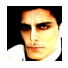

In [ ]:
img_rec = sess.run(generator(zp))
img_rec = (img_rec * 255).astype(np.uint8)
img_rec = img_rec.reshape((128, 128, 3))
plt.imshow(img_rec)
plt.axis('off')
fig = plt.gcf()
fig.set_size_inches( 1, 1 )
plt.imshow(img_rec)
plt.savefig('reconstructed-combined-loss.png', bbox_inches='tight', pad_inches=0, dpi=170)